In [117]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from lmfit import Parameters, minimize

from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')

# Width of the resonance in keV
width = 0.07
width_err = 0.01

# Boltzmann constant in keV/K
k = 8.617e-8
# Incident proton beam energy in keV

energies = [632.23, 991.86, 1213.08, 1587.49, 1799.75]

Ep = energies[4]

# Doppler effect
s_dopp = np.sqrt( 2 * 1.007 / 27 * Ep * k * ( 80 + 273 ) )

print(s_dopp)

0.06390271958044103


In [118]:
import stragg

import sys
stdout = sys.stdout

class Straggling:

    def __init__( self, element, energy, thick=0.1 ):
        self.energy = energy
        self.layer = stragg.Layer( element )
        self.layer.setThicknessStep( thick )
        self.prepare( )

    def stopping_power( self, x ):
        return self.layer.EvaluateZiegler( x )
    
    def eval( self, x ):
        return self.a * np.sqrt( x )

    def prepare( self ):

        em, dem, vv = self.energy, 0, 0
        em_array, dem_array, vv_array = [self.energy], [dem], [vv]
        while ( self.energy - em < 50 ):

            deml = self.layer.GetDEML(em)
            vvl  = self.layer.GetVVL(em)

            em  -= deml
            dem += deml
            vv = np.sqrt(vv*vv + vvl*vvl)

            em_array.append(em)
            dem_array.append(dem)
            vv_array.append(vv)

        popt, _ = curve_fit( lambda x, a: a * np.sqrt( x ), dem_array, vv_array )
        self.a = popt[0]

strag = Straggling( 13, Ep )

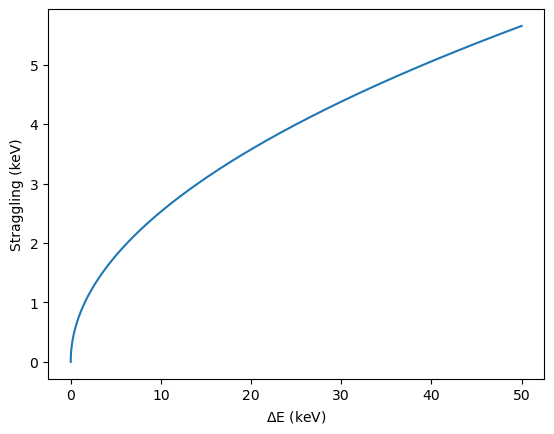

In [119]:
npoints = 5000

x = np.zeros( ( npoints ) )
y = np.zeros( ( npoints ) )

for i in range( npoints ):
    x[i] = i * 0.01
    y[i] = strag.eval( x[i] )


fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_ylabel( "Straggling (keV)" )
ax.set_xlabel("$\Delta$E (keV)")
#plt.savefig("results/straggPlot.png")
plt.show( )


In [120]:
def gaussian( x, x0, s ):
    return ( 1. / ( np.sqrt(2.*np.pi) * s ) ) * np.exp( -(x - x0)**2 / ( s*s*2 ) )

def cross_section( x0, theta, de ):
    return theta[1] / ( ( de - x0 )**2 + theta[1]**2 )

def integrand( x, theta, x0 ):
    de, de_res = x0 - x, x0 - theta[2]
    s_strag, s_beam = strag.eval( de ) / theta[-1], theta[0]
    sigma = np.sqrt( pow( s_beam, 2 ) + pow( s_strag, 2 ) + pow( s_dopp, 2 ) )
    xmin, xmax, steps = x - 4 * sigma, x + 4 * sigma, 1000
    step = ( xmax - xmin ) / steps
    array = x0 - np.linspace( xmin, xmax, steps )
    conv = theta[3] * np.sum( gaussian( array, de, sigma ) * cross_section( array, theta, de_res ) ) * step
    return conv

def profile( x, theta ):
    xmin = x.min( ) - 5
    y = np.zeros( shape=len( x ) )
    for idx in range( len( x ) ):
        y[idx] = integrate.quad( integrand, xmin, x[idx], args=(theta,x[idx]), epsabs=1e-04, epsrel=1e-04 )[0]
    return y

def model( x, theta ):
    sign = profile( x, theta[:-1] )
    back = theta[-1]
    return sign + back


In [121]:
data = np.loadtxt( 'data/Yield/Yield_1799_am.txt' )
data = data[data[:,0].argsort()]

def func( theta ):
    #print(theta)
    theta = list( theta.valuesdict().values() )
    mod   = model( x, theta )
    res   = ( obs - mod ) /(scaled)
    print( "Chi2: {:10.4f}".format(np.sum(res**2)), end="\r" )
    return res

x, obs, err = data[:,0], data[:,1], data[:,2]
#assigne each measurment run a different color to be used in the visualisation
color = ["c","m","y","black"]
log = []
for run in data[:,3]:
    log.append(color[int(run)])

params = Parameters()
params.add('beam',   value = 0.19139,         vary=True)
params.add('width',  value = 0.15691,        vary=False)
params.add('edge',   value = 1849.83465,      vary=True)
params.add('height', value = 16.91090,         vary=True)
params.add('scale',  value = 1,               vary=False)
params.add('back',   value = 2.64004,        vary=True)

factor = 1
scaled = err*factor

guess632 = [0.19139, 0.37597, 0.03953, 649.68740, 7.83267, -1.96816, 1.4, 31.93528, 1.03017, 649.5165, 0.03787]

guess992 = [0.25777, 0.02986, 0.07, 1019.11798, 34.96320, -0.29746, 2.7, 22.21712, 1.11086, 1018.9344, 0.04743]

guess992_II = [0.19139,  0.03795, 0.07000, 1019.13918, 36.17516, -2.05590, 2.7, 18.30662, 1.14416, 1018.9646, 0.04743]

guess1213 = [0.19139, 0.08394, 0.02222, 1246.68596, 7.97507, 0.57423, 1.4, 22.70655, 1.03212, 1246.499, 0.05246]

guess1587 = [0.19139, 0.00590, 0.01345, 1631.37643, 12.35802, -0.78820, 1.0, 18.65338, 0.98176, 1631.18065, 0.060016]

guess1799 = [0.19139, 0.15691, 0.03326, 1849.83465, 16.91090, 2.64004, 1.2, 24.73632, 0.91616, 1849.566, 0.06390]

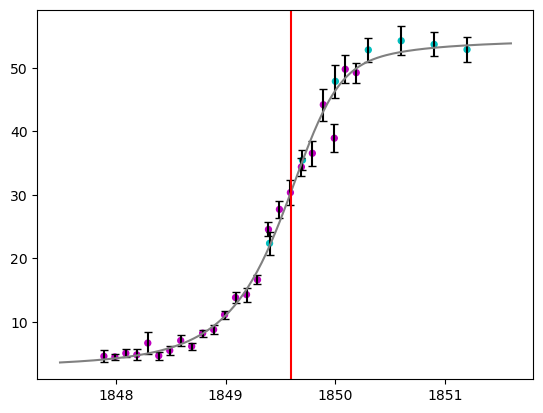

1849.5966331658292


In [122]:
theta = list( params.valuesdict().values() )

grid = np.linspace( x.min( ) - 0.4, x.max( ) + 0.4, 200 )

mod = model( grid, theta )

derivative1= np.diff(mod, axis=0)
derivative2= np.diff(derivative1, axis=0)

inflec = 0
for i in range(0, len(derivative2)):
    if derivative2[i] > 0 and derivative2[i+1]< 0:
        inflec = grid[i]
        break



plt.errorbar( x, data[:, 1], yerr=data[:, 2], fmt="none", color = "black", capsize= 3)
plt.scatter( x, data[:, 1], color = log, s = 18)
plt.plot( grid, mod, '-',color = "gray")
plt.axvline(inflec, 0, 100, color = "r")
plt.show()
print(inflec)

In [75]:
out = minimize(func, params, method="leastsq")



print(f'Nvars {out.nvarys}              Ndata {out.ndata}')
print(f'Chi2 {out.chisqr:11.5f}     Chi2 / Ndof {out.redchi:11.5f}')

theta, error = [], []
print("----------------------------------------")
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    theta.append( param.value )
    error.append( param.stderr )
    if( param.stderr == None ): param.stderr = 0
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

Nvars 4              Ndata 31
Chi2    75.44538     Chi2 / Ndof     2.79427
----------------------------------------
Parameter    Value       Stderr
beam        0.00006   343.18593
width       0.39000     0.00000
edge     1849.90294     0.04404
height     20.26242     0.78377
scale       1.00000     0.00000
back       -0.56518     0.51923


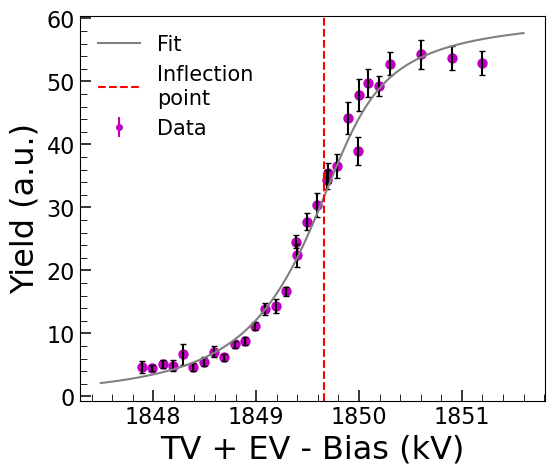

1849.6585929648243


In [76]:
mod = model( grid, theta )

edge = 0
count = 0
for name, param in out.params.items():
    edge = param.value 
    if count == 2:
        break
    count += 1

derivative1= np.diff(mod, axis=0)
derivative2= np.diff(derivative1, axis=0)

inflec = 0
for i in range(0, len(derivative2)):
    if derivative2[i] > 0 and derivative2[i+1]< 0:
        inflec = grid[i]
        break

#create an errorbar handle to be used in the plot
xdata = np.linspace(0,5,5)
y = xdata
yerr = np.random.rand(5)

#specify font
hfont = {'fontname':'sans-serif'}


fig, ax = plt.subplots(figsize = (6,5))
errorb = ax.errorbar(x=xdata, y=y, yerr= yerr, color = "m", fmt = "o", label = "Data", markersize = 4)
ax.clear()


ax.errorbar( x, data[:, 1], yerr= scaled, fmt = "none",color = "black", capsize = 2)
ax.plot( grid, mod, '-', label="Fit", color = "gray") 
ax.scatter(x, data[:, 1], color = "m", s = 42)
#plt.axvline(x = edge, color = 'r', label = 'Resonance center', ls = "--") 
ax.axvline(x = inflec, color = 'r', label = 'Inflection \npoint', ls = "--")



#reorder handles so data is on top in the legend 
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([errorb])

ax.set_xlabel( "TV + EV - Bias (kV)",  fontsize = 23, **hfont)
ax.set_ylabel( "Yield (a.u.)", fontsize = 23, **hfont)
ax.minorticks_on()
ax.tick_params(axis = "both", direction = "in", labelsize = 16, length = 8, width = 1.1)
ax.tick_params(which = "minor", axis = "both", direction = "in",length = 5, width = 0.6)
ax.legend(handles = handles, frameon = False, prop = {"family" : ["sans-serif"], "size" : 15})

#hide every other tick label
""" labelX = ax.xaxis.get_ticklabels()
for lx in labelX[::2]:
    lx.set_visible(False)

labelY = ax.yaxis.get_ticklabels()
for ly in labelY[::2]:
    ly.set_visible(False) """

#plt.savefig( "data/results/1587.png", dpi = 800, bbox_inches = "tight")
plt.show( )

print(inflec)

In [11]:
f = open("/home/zetta/Projects/DCF/Data/Model/992_II.txt", "w")
for l in range(0, len(mod)):
    f.write(str(grid[l])+ " " + str(mod[l]) + "\n") 
f.close()

In [ ]:

#resonance width upper bound for 1213keV
guess632 = [0.21000, 0.00000, 0.27773, 0.04506, 649.81607, 7.55193, -1.75561, 1.4, 36.92715, 1.19120, 649.571, 0.03787]

guess632 = [0.42729, 0.01078, 0.00718, 0.01951, 649.66887, 6.21216, 0.06471]

guess632 = [0.26311, 0.26183, 0.23820, 0.22602, 649.81937, 7.40582, -1.56297, 1.6, 28.22514, 0.94084, 649.553, 0.03787]

guess632 = [0.45605, 0.00169, 0.01000, 0.00000, 649.83260, 6.58237, -0.47961, 28.92890, 0.93319, 649.534, 0.03787]

guess632 = [0.16983, 0.30933, 0.34478, 0.17814, 649.75597, 7.74454, -1.91807, 66.82045, 2.22735]

guess992_II_amended = [0.18716, 0.07, 1019.11789, 35.97766, -2.29360, 51.89803, 2.35900, 1018.9420, 0.04743]

#resonance fixed beam from model for 1213keV
guess1213 = [0.18282, 0.09146, 1246.68561, 8.01602, 0.51622, 11.24852, 0.51130, 1246.4566 , 0.05246]

guess1213 = [0.22457, 0.10802, 1246.68606, 8.32022, 0.00036, 14.39537, 0.65433, 1246.4566 , 0.05246]

guess1213 = [0.24844, 0.03794, 0.01000, 0.07911, 1246.68876, 7.58585, 1.12750, 1.4, 22.79554, 1.08550]

guess1213 = [0.27082, 0.00768, 0.00431, 0.01240, 1246.68989, 7.55326, 1.17241, 1.6, 16.56651, 0.78888]

#resonance width upper bound 1587keV
guess1587 = [0.00089, 0.2, 1631.33850, 15.13618, -4.52014, 10.50533, 0.55291, 1631.1495 , 0.060016]

#resonance fixed beam from average, including 1213keV, for 1587keV

guess1587 = [0.2100, 0.00224, 0.00034, 1631.33404, 12.46592, -0.54671, 23.28093, 1.22531, 1631.1592, 0.060016]

guess1587 = [-0.00003, 202.85758, 0.20000  , 1631.33798, 15.13117, -4.52134, 42.02745,  2.21197]

#resonance with beam energy as a min-max range
guess1587 = [0.19013, 0.01645, 0.00480, 0.00711, 1631.36131, 12.65867, -0.37391, 13.37996, 0.74333]

guess1587 = [0.17409, 0.05217, 0.03207, 0.05135, 1631.32765, 12.66312, -0.15417, 11.65271, 0.64737]


guess1799 = [0.00000, 0.4500, 1849.81998, 20.72172, -0.85075, 69.83529, 2.58649]
#resonance with narrower width for 1799keV

guess1799 = [0.25000, 0.07779, 0.11473, 0.09652, 1849.83722, 16.57545, 3.10092, 1.2, 25.87016, 0.99501]

#resonance fixed beam from average for 1799keV
guess1799 = [0.22457, 0.13412, 1849.83581, 16.72618, 2.88970, 9.56708, 0.35434, 1849.566, 0.06390]

guess1799 = [0.36589, 0.00275, 0.01000, 1849.84654, 15.83584, 4.16397, 1.2, 23.74463, 0.87943]

guess1799 = [0.30000, 0.10430, 0.12694, 0.10435, 1849.78714, 16.69302, 0.96810, 3.28231, 35.06429, 1.34863]

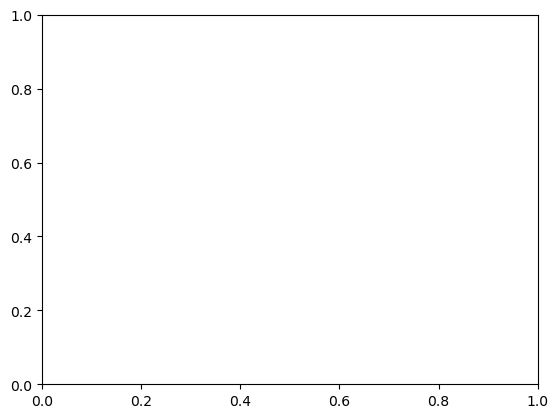

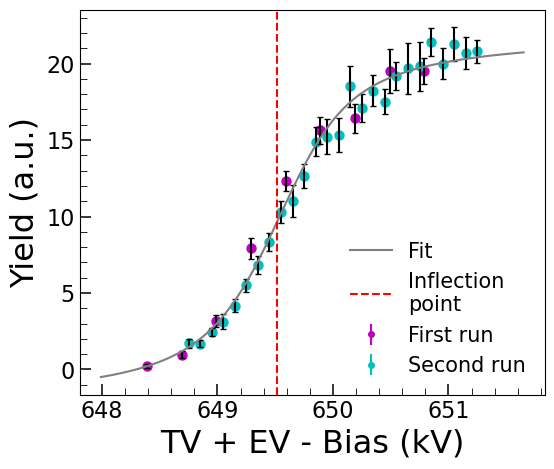

649.5165326633165


In [84]:
sep = np.loadtxt( 'data/Yield/Yield_632_am.txt' )

mod = model( grid, theta )

edge = 0
count = 0
for name, param in out.params.items():
    edge = param.value 
    if count == 2:
        break
    count += 1

#find the inflection point to get the center of the resonance
derivative1= np.diff(mod, axis=0)
derivative2= np.diff(derivative1, axis=0)

inflec = 0
for i in range(0, len(derivative2)):
    if derivative2[i] > 0 and derivative2[i+1]< 0:
        inflec = grid[i]
        break


#create a fake errorbar handle to be used in the later plot
xdata = np.linspace(0,5,5)
y = xdata
yerr = np.random.rand(5)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
errorb = ax.errorbar(x=xdata, y=y, yerr= yerr, color = "m", fmt = "o", label = "First run", markersize = 4)
errorb1 = ax.errorbar(x=xdata, y=y, yerr= yerr, color = "c", fmt = "o", label = "Second run", markersize = 4)
ax.clear()

#add a cutoff for the data to be plit into runs
cutoff = 9

#specify font
hfont = {'fontname':'sans-serif'}

#figure plot with multiple runs
fig, ax = plt.subplots(figsize = (6,5))
ax.errorbar( x, data[:, 1], yerr= scaled, fmt = "none",color = "black", capsize = 2)
ax.plot( grid, mod, '-', label="Fit", color = "gray") 
ax.scatter(sep[0:cutoff,0], sep[0:cutoff,1], color = "m", s = 42)
ax.scatter(sep[cutoff:,0], sep[cutoff:,1], color = "c", s = 42)
#plt.axvline(x = edge, color = 'r', label = 'Resonance center', ls = "--") 
ax.axvline(x = inflec, color = 'r', label = 'Inflection \npoint', ls = "--")

#set label and tickmark parameters
ax.set_xlabel( "TV + EV - Bias (kV)",  fontsize = 23, **hfont)
ax.set_ylabel( "Yield (a.u.)", fontsize = 23, **hfont)
ax.minorticks_on()
ax.tick_params(axis = "both", direction = "in", labelsize = 16, length = 8, width = 1.1)
ax.tick_params(which = "minor", axis = "both", direction = "in",length = 5, width = 0.6)

#reorder handles so data is on top in the legend 
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([errorb])
handles.extend([errorb1])
ax.legend(handles = handles, frameon = False, prop = {"family" : ["sans-serif"], "size" : 15})

#hide every other tick label
""" labelX = ax.xaxis.get_ticklabels()
for lx in labelX[::2]:
    lx.set_visible(False)

labelY = ax.yaxis.get_ticklabels()
for ly in labelY[::2]:
    ly.set_visible(False) """

plt.savefig( "data/results/632.png", dpi = 800, bbox_inches = "tight")
plt.show( )

print(inflec)